# Fake News dataset exploration & preprocessing
by Marcin Rybok

In [1]:
import pickle
import pandas as pd
import seaborn as sns

from collections import Counter

In [2]:
bodies  = pd.read_csv('../../data/fake_news/bodies.csv')
stances = pd.read_csv('../../data/fake_news/stances.csv')
test_bodies = pd.read_csv('../../data/fake_news/competition_test_bodies.csv')

bodies = pd.concat((bodies, test_bodies))

In [3]:
# Check for null values
bodies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 903
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      2587 non-null   int64 
 1   articleBody  2587 non-null   object
dtypes: int64(1), object(1)
memory usage: 60.6+ KB


In [4]:
stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [5]:
# Check for duplicates
unique_count = bodies.groupby('articleBody').agg(['unique', 'nunique'])
duplicates = unique_count[unique_count['Body ID']['nunique'] > 1]['Body ID']['unique'].tolist()

print(f'Number of body duplicates: {len(duplicates)}')

Number of body duplicates: 28


In [6]:
# Map second duplicate in a pair to ID of the first Body
duplicates = {non_first_duplicate: ids[0] for ids in duplicates for non_first_duplicate in ids[1:]}

# Remove duplicates
old_len = len(bodies)
bodies = bodies.drop_duplicates(subset='articleBody', keep='first')

print(f'Removed {old_len - len(bodies)} duplicates')
print(f'Number of bodies after duplicate removal: {len(bodies)}')

Removed 28 duplicates
Number of bodies after duplicate removal: 2559


In [7]:
# Fix the Body IDs of removed duplicate bodies in the Stances table
stances['Body ID'] = stances['Body ID'].apply(lambda body_id: duplicates[body_id] if body_id in duplicates else body_id)

# Remove duplicated Headline - Body pairs
old_len = len(stances)
stances = stances.drop_duplicates(subset=['Headline', 'Body ID'], keep='first')

print(f'Removed {old_len - len(stances)} duplicates')
print(f'Number of headline-body pairs after duplicate removal: {len(stances)}')

Removed 434 duplicates
Number of headline-body pairs after duplicate removal: 49538


In [8]:
unique_heads = set(stances["Headline"])

print(f'Number of unique headlines: {len(unique_heads)}')

Number of unique headlines: 1648


In [9]:
# Replace Headline by ID in Stances table
# Useful later for faster tokenizing (1,500 instead of 50,000 headlines)
max_body_id = max(stances['Body ID']) + 1
head_to_id = {headline: idx + max_body_id for idx, headline in enumerate(unique_heads)}

stances['Headline'] = stances['Headline'].apply(lambda headline: head_to_id[headline])

stances = stances.rename(lambda column: 'Headline ID' if column == 'Headline' else column, axis=1)

In [10]:
# Check for data points with conflicting labels
num_conflicts = (stances.groupby(['Headline ID', 'Body ID']).agg('nunique') > 1)['Stance'].sum()

print(f'Num conflicting data points: {num_conflicts}')

Num conflicting data points: 0


In [11]:
# Check class distribution
dist = sorted(Counter(stances['Stance']).items(), key=lambda x: x[1])

print(f'Dataset size: {len(stances)}\n')
print('Class distribution:')

for label, count in dist:
    print(f'    {label:<9s}: {count * 100 / len(stances):>5.2f}%, ({count:>5d})')

Dataset size: 49538

Class distribution:
    disagree :  1.67%, (  829)
    agree    :  7.35%, ( 3643)
    discuss  : 17.77%, ( 8804)
    unrelated: 73.20%, (36262)


## Dataset partitioning problem

For ML we need to split the dataset into train / validation / test sets.
The project [GitHub repository](https://github.com/FakeNewsChallenge/fnc-1) offers a ready test set, so I am going to use it.
I need to split the available dataset to train and validation only.

Splitting aims:
- Maintain original class distribution in train & valid set
- The splits are mutually exclusive

**Problem**:
The mapping between headlines and bodies is many-to-many.
We cannot have a headline that occurs both in train set and validation set pair.
Otherwise, we have data leakage from train to the validation set.
Validation set will produce over-optimistic estimates in hyperparameter tunning.

We need to assign each headline and body either to train or validation dataset.
Then remove the Stance pairings in which headline and body are not in the same set.
*(The removal is temporary for hyperparameter tunning only. After finding good hyperparameters we retrain on the entire dataset.)*
There are $2^{N}$ possible splits to consider ($N$ being number of bodies and headlines).
Combinatorial problem - too costly to consider all splits.
The problem is a graph clustering one so use graph search similar to breadth-first search (BFS) to find a suboptimal split.

New splitting aims:
- Maintain original class distribution in train & valid set
- The pairing splits are mutually exclusive
- Each Headline and Body is assigned to train or valid set only.
- Minimize the number of inter-split Body-Headline connections, to maximize the number of training examples.

The implementation is in `fake_news.util.split_data` function.

In [12]:
from fake_news.util import split_data

In [13]:
stances = split_data(stances, valid_size=0.05, seed=6)

  0%|          | 0/2476 [00:00<?, ?it/s]

In [14]:
# Test set preprocessing
test_stances = pd.read_csv('../../data/fake_news/competition_test_stances.csv')

test_stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25413 entries, 0 to 25412
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  25413 non-null  object
 1   Body ID   25413 non-null  int64 
 2   Stance    25413 non-null  object
dtypes: int64(1), object(2)
memory usage: 595.7+ KB


In [15]:
old_len = len(test_stances)
print(f'Original test set size: {old_len}')

# Fix the Body IDs of removed duplicate bodies in the test stances table
test_stances['Body ID'] = test_stances['Body ID'].apply(lambda body_id: duplicates[body_id] if body_id in duplicates else body_id)

# Remove duplicated Headline - Body pairs
test_stances = test_stances.drop_duplicates(subset=['Headline', 'Body ID'], keep='first')

print(f'Removed {old_len - len(test_stances)} duplicates from test set')

old_len = len(test_stances)

# Remove any test set example, of which body or headline occurs in train or validation
old_bodies = set(pd.read_csv('../../data/fake_news/bodies.csv')['Body ID'])
logical_idx = test_stances.apply(lambda row: row['Headline'] not in head_to_id and row['Body ID'] not in old_bodies, axis=1)
test_stances = test_stances[logical_idx]

print(f'Removed {old_len - len(test_stances)} test set examples occurring also in train or validation set')

test_stances['Split'] = ['test'] * len(test_stances)
max_head_id = max(head_to_id.values()) + 1

for idx, head in enumerate(set(test_stances['Headline'])):
    head_to_id[head] = idx + max_head_id

test_stances['Headline'] = test_stances['Headline'].apply(lambda head: head_to_id[head])

test_stances = test_stances.rename(lambda column: 'Headline ID' if column == 'Headline' else column, axis=1)

print(f'Preprocessed test set size: {len(test_stances)}')

stances = pd.concat((stances, test_stances))

Original test set size: 25413
Removed 265 duplicates from test set
Removed 370 test set examples occurring also in train or validation set
Preprocessed test set size: 24778


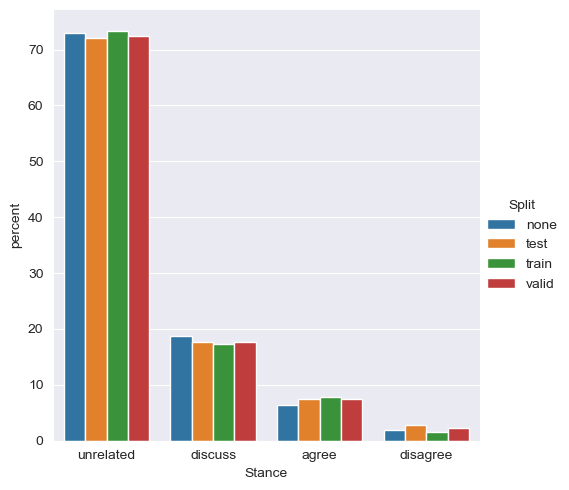

In [16]:
split_display = stances.groupby('Split')['Stance'].value_counts(normalize=True).mul(100).rename('percent')

split_display.reset_index().pipe((sns.catplot, 'data'), x='Stance', y='percent', hue='Split', kind='bar');

In [17]:
labels = {'unrelated': 0, 'agree': 1, 'disagree': 2, 'discuss': 3}

print(f'{" ":<5s} | total | data % | unrelated | {"agree":>8s} | disagree | {"discuss":>8s}')
print("-------------------------------------------------------------------")

for split in ['train', 'valid', 'none']:
    filtered = stances[stances['Split'] == split]
    n = len(filtered)
    total = sum(stances['Split'] != 'test')

    aux = lambda label: f'{((filtered["Stance"] == label).sum() * 100 / n):>8.2f}%'
    str_rep = " |".join([aux(label) for label in labels])

    print(f'{split:<5s} | {n:5d} | {(n * 100 / total):>5.2f}% |', str_rep)

      | total | data % | unrelated |    agree | disagree |  discuss
-------------------------------------------------------------------
train | 31161 | 62.90% |    73.40% |    7.80% |    1.52% |   17.27%
valid |  2501 |  5.05% |    72.49% |    7.52% |    2.36% |   17.63%
none  | 15876 | 32.05% |    72.92% |    6.45% |    1.86% |   18.77%


The algorithm I have used for data splitting produces well-balanced splits in terms of classes.
Drawback: many examples must be rejected.
I have tried different expansion method, that selected the least connected nodes for expansion in graph search.
The previous method rejected significantly less inter-split connections, but split class distributions varied significantly.
*(3 times lower proportion of "agree" examples in a train set compared to validation)*
There are no free-lunches :(

**Finally, I use 5% of Headline-Body pairings as the validation set. 63% pairs are left for training. The remaining 32% of data must be left out from the hyper-parameter tunning process, to prevent same examples in training and validation sets.**
*(percentages do not consider the test set examples)*
*(I use 5% of data in validation set because when I have tried 10% the train set had only 40% of examples)*

#### Baseline
Baseline simply predicts the most common *"unrelated"* class, yielding 72.49% accuracy on the validation set.
The classes are unbalanced, so accuracy is not a good performance metric.
F1-score should be used instead.

### Digression
Creating more *"unrelated"* pairings by randomly assigning more headlines to bodies is a good data augmentation method.
Its unlikely that such random assignment would produce a *"related"* pair.
However, most of the pairings are already *"unrelated"*.
Headlines are paired with multiple bodies.
The method was probably already used in the dataset creation.

### Task & solution
The task is to determine whether Headline matches the article Body.
It is very similar to sentence entailment.
BERT is pre-trained to predict whether one sentence supersedes another, so it is naturally suited for the task.
I am going to represent each Headline-Body pair as:
\<CLS\> Headline \<SEP\> Body \<SEP\>
So I will tokenize each Headline and Body.
Then I will feed the above representation to BERT.
From BERT's output, I will extract the last hidden state representation for the \<CLS\> token only.
Then I will feed the BERT-produced contextualized embeddings to a simple classifier head.
I will train the classifier head only, as I have no time to fine-tune BERT.
Hence, the BERT embedding for each Headline-Body pair will be produced once and stored.

### Caveats
The task is different from entailment in that the article Bodies are quite long.
Bodies often have lengths in thousands of tokens.
BERT accepts a sequence of length max 512.
Hence, I am going to always use the full tokenized Headline, but I will truncate the Body, so that together the:
\<CLS\> Headline \<SEP\> truncated-Body \<SEP\>
representation matches the maximum 512 tokens.
I will use only the initial Body tokens.
This will downgrade the performance.

### Alternatives:
- Instead of using the initial part of the Body, try using middle or random part. Might have a higher chance of containing key info for classification.
- Use multiple Body parts *(for example, start, middle and end)*: encode each as before, feed each representation separately into BERT. From each BERT output extract \<CLS\> token embedding, concatenate such embeddings together and feed them into classifier. Covers more article body text, but it is more computationally expensive. I have tried using end part also, but it took too long for my Nvidia RTX 2060 to compute the embeddings.
- **Update** - concatenation would be bad if in train set the differentiating info always occurs in the last sentence the classifier will completely neglect the \<CLS\> token representation of the first sentence. If then in a test body, the differentiating info is in the first sentence, the classifier does not know how to handle this. It's better to compress the \<CLS\> representations of multiple Body parts with aggregate function such as componentwise-max. MAX or MIN will be better than SUM or MEAN as they have robust representations even when the number of compressed \<CLS\> tokens varies between examples (for longer Bodies we can embed more sentences and still take aggregate over the embeddings). Most sentences will be *"unrelated"* to the classification task, and this will squash the aggregate embedding representations, whereas MAX changes the aggregate representation robustly in response to just one relevant sentence no matter how many embeddings we are aggregating over.
- Produce representations in Information Retrieval (IR) fashion. Case fold, tokenize, remove stop words, stem the Headlines & Bodies. Then represent each document sparsely based on the dictionary of left words in the dataset and try to build a classifier on top of this. Might be suitable due to lengthy Bodies - IR deals better with lengthy documents & semantics only.
- The task is also similar to text summarization, where we try to highlight important sentences in a document. Typically, one sentence in body will inform us whether the Headline matches it, so the task might be reduced to finding such most significant sentence. If I had more time, I would also look for solutions in this field. Example: [Text Summarization with Pretrained Encoders](https://arxiv.org/pdf/1908.08345.pdf)

In [18]:
text_dicts = {
    'head': {head_id: {'text': text, 'input_ids': []} for text, head_id in head_to_id.items()},
    'body': {body_id: {'text': text, 'input_ids': []} for body_id, text in bodies.itertuples(index=False)}
}

with open('../../preprocessed/fake_news/data/text_dicts.pkl', 'wb') as file:
    pickle.dump(text_dicts, file)

for split in ['train', 'valid', 'none', 'test']:
    stances[stances['Split'] == split][stances.columns[:-1]].to_csv(f'../../preprocessed/fake_news/data/{split}.csv', index=False)

In [19]:
import transformers
import matplotlib.pyplot as plt

from common.util import tokenize_texts

transformers.logging.set_verbosity_error()

In [20]:
# Tokenize the texts, so they can be fed into BERT.
tokenize_texts(
    in_file='../../preprocessed/fake_news/data/text_dicts.pkl',
    out_file='../../preprocessed/fake_news/data/text_dicts.pkl',
    verbose=True
)

tokenization:   0%|          | 0/5091 [00:00<?, ?it/s]

Check Headline-Body pair length distribution

Maximal Headline-Body length in terms of BERT tokens:          6244
Percent of Headline-Body representations exceeding 509 tokens: 33.8%


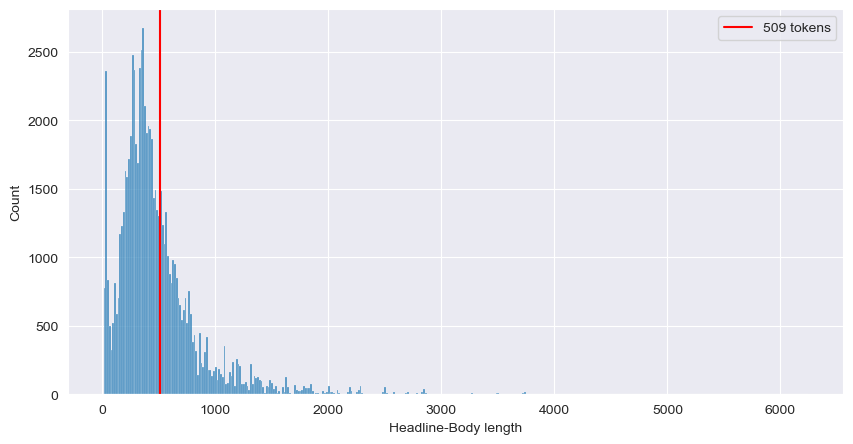

In [21]:
with open('../../preprocessed/fake_news/data/text_dicts.pkl', 'rb') as file:
    text_dicts = pickle.load(file)

lengths = []

for row in stances.itertuples(index=False):
    head_id, body_id, _, _ = row

    head_len = len(text_dicts['head'][head_id]['input_ids'])
    body_len = len(text_dicts['body'][body_id]['input_ids'])

    lengths += [head_len + body_len]

num_exceeding = len([1 for length in lengths if length > 509]) * 100 / len(lengths)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.axvline(x=509, ymin=0, ymax=1, c='r', label='509 tokens')
ax.legend()

sns.histplot(lengths, ax=ax)
ax.set_xlabel('Headline-Body length')
print(f'Maximal Headline-Body length in terms of BERT tokens:          {max(lengths)}')
print(f'Percent of Headline-Body representations exceeding 509 tokens: {num_exceeding:.1f}%')